# RAG Work Flow

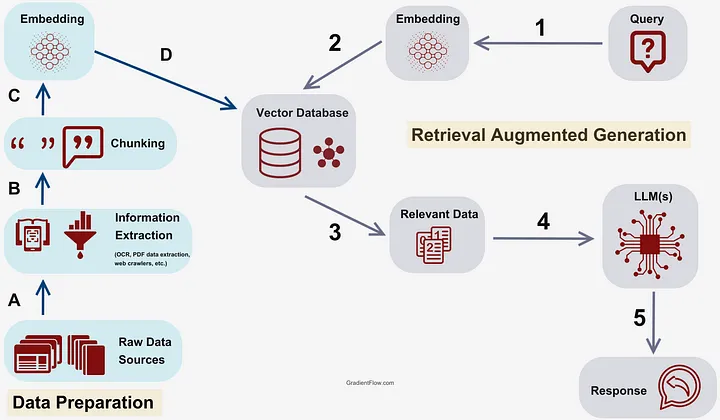

# Install necessary dependencies

In [ ]:
%pip install --upgrade --quiet langchain_community langchain beautifulsoup4 faiss-cpu langchain-groq langchain-huggingface gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 503.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9

In [ ]:
# Load docs
import os
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceInferenceAPIEmbeddings
from google.colab import userdata
from langchain_community.vectorstores import FAISS
from langchain import hub
from langchain.chains import RetrievalQA
from langchain_groq import ChatGroq


# set environment of api keys
Hug_api_key=userdata.get('hug_api_key') # huggingface api
os.environ["GROQ_API_KEY"] = userdata.get("groq_api_key") # groq api
os.environ['LANGCHAIN_API_KEY']=userdata.get('LANGCHAIN_API_KEY') # langchain api

# set langsmith to trach the calls
LANGCHAIN_TRACING_V2="true"
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_PROJECT="Rag based approach"

# Load website data
loader = WebBaseLoader("https://purposetechnology.in/")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=50)
all_splits = text_splitter.split_documents(data)

# embeding initialisation
embeddings = HuggingFaceInferenceAPIEmbeddings(api_key=Hug_api_key, model_name="sentence-transformers/all-MiniLM-l6-v2")

# Store splits
vectorstore = FAISS.from_documents(documents=all_splits, embedding=embeddings)

# LLM
llm = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    max_tokens=600,
    timeout=None,
    max_retries=2,
)


# See full prompt at https://smith.langchain.com/hub/rlm/rag-prompt
prompt = hub.pull("rlm/rag-prompt")

qa_chain = RetrievalQA.from_llm(
    llm, retriever=vectorstore.as_retriever(), prompt=prompt
)

qa_chain("What is purpose technology?")

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:5515: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))
<ipython-input-2-f00cdce963d0>:54: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  qa_chain("What is purpose technology?")


{'query': 'What is purpose technology?',
 'result': 'Purpose Technology is a company that provides training, project guidance, and technical services to students and industries. They offer a range of services including software and hardware development, 3D printing solutions, and project development support. Their goal is to deliver end-to-end solutions and help clients discover, plan, design, and manage their technology solutions.'}

In [ ]:
import gradio as gr

# Define a function to handle user messages and generate responses
def respond(message, history: list[dict]):
    # Focus on the latest user message only
    query = message

    # Use the qa_chain to generate a response
    response_text = qa_chain(query)["result"]

    # Append the assistant's response to the history
    response = {"role": "assistant", "content": response_text}
    yield response

# Create a Gradio ChatInterface using the respond function
demo = gr.ChatInterface(respond, type="messages")

# Launch the Gradio interface with debugging enabled
if __name__ == "__main__":
    demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://96304bac55609ff9e2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
